## Demo notebook for analyzing the TerraClimate dataset

This notebook provides an example of accessing the Terraclimate dataset on Azure. TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019.

This example will show you how temperature has increased over the past 60 years across the globe.

TerraClimate data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe. We recommend that substantial computation depending on TerraClimate data also be situated in West Europe. If you are using TerraClimate data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports and constants

In [1]:
import xarray as xr
import zarr
import os
import fsspec
import numpy as np

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

storage_account_name = 'cpdataeuwest'
zarr_folder_name = 'cpdata/raw/terraclimate/4000m/raster.zarr'

### Open the dataset using fsspec and zarr

In [2]:
mapper = fsspec.get_mapper('az://' + zarr_folder_name,
                           account_name=storage_account_name)
ds = xr.open_zarr(mapper, consolidated=True)

Check out the dataset to see the components that you can work with. There are three coordinates (time, x, y) and twenty different variables which can be accessed via those coordinates. Some of the variables vary over time (e.g. temperature, precipitation, evaporation), while others are constant through time (e.g. elevation, a domain mask). We can access this lazily without actually loading the file into memory.

In [3]:
ds

,Array,Chunk
Bytes,111.08 GB,99.53 MB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,111.08 GB,99.53 MB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Analyze and plot global temperature

We can quickly plot a map of one of the variables. In this case, we are downsampling (coarsening) the dataset for easier plotting.

[########################################] | 100% Completed | 10.8s


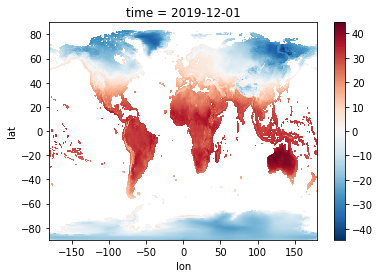

In [4]:
da = ds.isel(time=-1)['tmax'].coarsen(lat=8, lon=8).mean().load()
da.plot()

Let's see how temperature has changed over the observational record, when averaged across the entire domain. Since we'll do some other calculations below we'll also add `.load()` to execute the command instead of specifying it lazily.  Note that there are some data quality issues before 1965 so we'll start our analysis there.

[########################################] | 100% Completed |  2min 25.3s


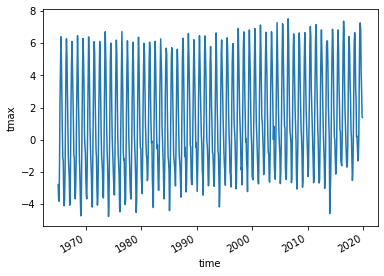

In [5]:
temperature = ds['tmax'].sel(time=slice('1965', None)).mean(dim=['lat', 'lon']).load()
temperature.plot()

With all the seasonal fluctuations (from summer and winter) though, it can be hard to see any obvious trends. So let's try grouping by year and plotting that timeseries.

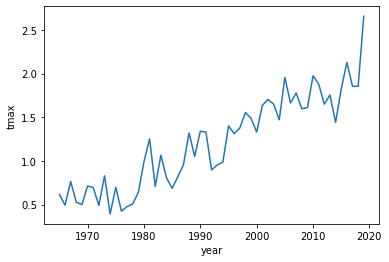

In [6]:
temperature.groupby('time.year').mean().plot()

Now the increase in temperature is obvious, even when averaged across the entire United States domain.

Now, let's see how those changes are different in different parts of the world. And let's focus just on summer months, when it's hottest. Let's take a climatological slice at the beginning of the period and the same at the end of the period, calculate the difference, and map it to see how different parts of the world have changed differently.

First we'll just grab the summer months.

[########################################] | 100% Completed |  1min 19.8s
[########################################] | 100% Completed |  1min 20.8s


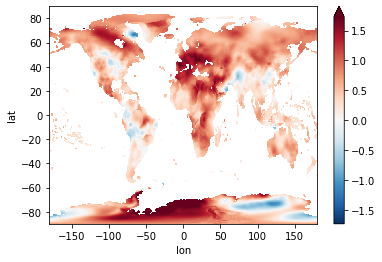

In [7]:
summer_months=[6,7,8]
ds = ds.tmax.where(ds.time.dt.month.isin(summer_months), drop=True)

early_period = slice('1958-01-01', '1988-12-31')
late_period = slice('1988-01-01', '2018-12-31')

early = ds.sel(time=early_period).mean(dim='time').compute()
late = ds.sel(time=late_period).mean(dim='time').compute()

(late-early).coarsen(lat=8, lon=8).mean().plot(robust=True)

This shows us that changes in summer temperature haven't been felt equally around the globe.  Note the enhanced warming in the polar regions, a phenomenon known as "Arctic amplification".